In [1]:
library(raster)
library(sp)
library(tidyverse)
library(rgdal)
library(readxl)
library(rgeos)
library(RColorBrewer)
#wd <- "AICCRA/CSAIPs/OUTPUT_KEN_SEN"

Loading required package: sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks raster::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select()

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /usr/share/proj
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_wa

OGR data source with driver: ESRI Shapefile 
Source: "/cluster01/workspace/AICCRA/CSAIPs/data/shapefile/ne_10m_admin_0_countries.shp", layer: "ne_10m_admin_0_countries"
with 255 features
It has 94 fields
Integer64 fields read as strings:  POP_EST NE_ID 


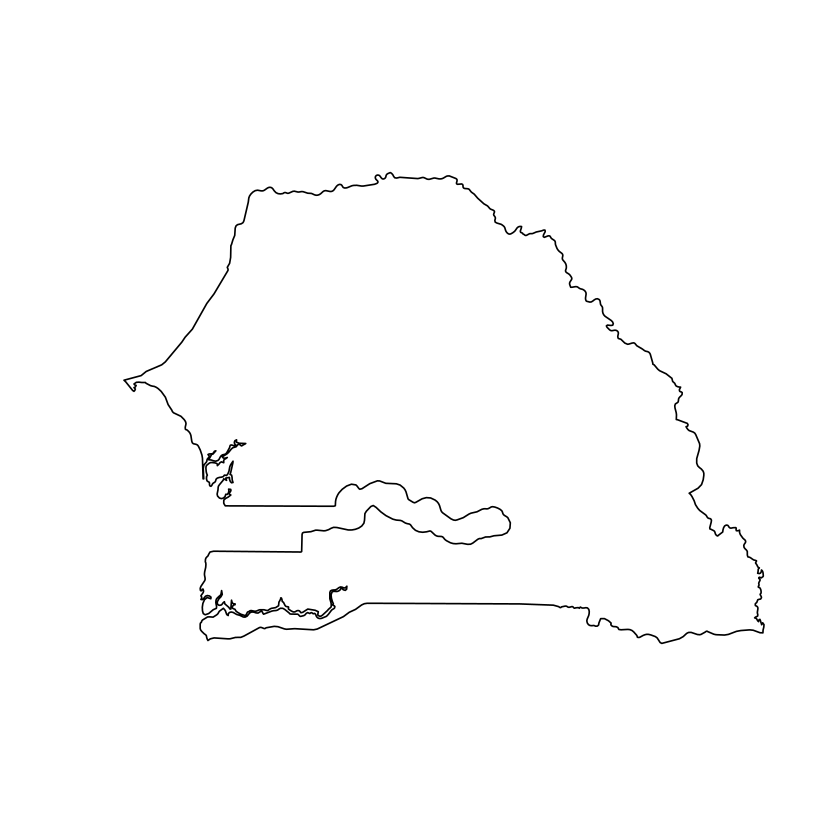

In [4]:
shp <- readOGR("AICCRA/CSAIPs/data/shapefile/ne_10m_admin_0_countries.shp")
sadc <- c("SEN")
shp@data <- shp@data %>%
  dplyr::mutate(CG_REG=ifelse(ADM0_A3 %in% sadc, "SADC", NA))
#remove all of the NA regions
shp <- shp[which(!is.na(shp$CG_REG)),]
#dissolve polygons based on CGIAR region
shp_dis <- gUnaryUnion(shp, id = shp@data$CG_REG)
shp_dis <- SpatialPolygonsDataFrame(shp_dis, data.frame(CG_REG=names(shp_dis),
                                                        row.names=names(shp_dis),
                                                        stringsAsFactors=FALSE))
writeOGR(shp_dis, dsn=paste(wd,"/region_shapefiles/",sep=""), layer="rbj_SEN", 
         driver="ESRI Shapefile", overwrite_layer = TRUE)
writeOGR(shp, dsn=paste(wd,"/region_shapefiles/",sep=""), layer="rbj_regions_SEN", 
         driver="ESRI Shapefile", overwrite_layer = TRUE)
#check the region
plot(shp_dis)

In [14]:
#create ID of row column
shp@data <- shp@data %>% dplyr::mutate(IDROW=1:nrow(shp)) %>% dplyr::relocate(IDROW, .before=featurecla)
rbj_xt <- extent(shp)
rbj_xt@xmin <- rbj_xt@xmin - 2; rbj_xt@xmax <- rbj_xt@xmax + 2
rbj_xt@ymin <- rbj_xt@ymin - 2; rbj_xt@ymax <- rbj_xt@ymax + 2

In [16]:
rhaz <- raster("AICCRA/Data/hazards_map/hazard_classes.tif")
#create countries mask and then mask hazard layer
cmsk <- raster::rasterize(shp, rhaz, field="IDROW")
rhaz <- raster::mask(rhaz, cmsk) %>%
        raster::crop(., rbj_xt)
crs(rhaz) <- shp@proj4string
cmsk <- raster::crop(cmsk, rbj_xt)
#write PKT's hazard map, cropped to CG regions
writeRaster(rhaz, paste(wd,"/hazard_map_masked_sen.tif",sep=""), overwrite=TRUE)

In [17]:
#bin hazard map
rhaz_bin <- rhaz
rhaz_bin[which(rhaz_bin[] != 0)] <- 1
#hazard legend
haz_lab <- data.frame(HAZARD=seq(0,10,by=1),
                      HAZ_LAB=c("No hazard", "Extremely high climate variability (CV rainfall > 30%) (ExC)", "High climate variability (HCV)", "Thermal stress (THI)",
                                "Climate variability (ExC+HCV) + THI", "CV + Drought (D)", "CV + Flood (F)", "CV + THI + D", "CV + THI + F",
                                "CV + D + F", "CV + THI + D + F"))

In [20]:
#area raster (in km2)
area_rs <- raster::area(cmsk) %>%
  raster::mask(., cmsk)
#load rural pop layer from JK (5 arc-min) (people)
rpop <- raster("ONECGIAR/Data/population/cell5m_ruralpop_2020_v3.tif") %>%
  raster::resample(., cmsk, method='ngb') %>%
  raster::mask(., cmsk)
#create crop layer, change names by country
if (!file.exists(paste(wd,"/crops_vop/crops_vop_spam_ssa_2017.tif",sep=""))) {
  vcrop <- list.files(path="AICCRA/CSAIPs/data",
                      pattern="\\_A.tif", full.names=TRUE)
  vcrop <- raster::stack(vcrop) %>%
    raster::crop(., cmsk) %>%
    sum(., na.rm=TRUE)
  vcrop <- raster::mask(vcrop, cmsk)
  writeRaster(vcrop, paste(wd,"/crops_vop_spam_ssa_2017_sen.tif",sep=""))
} else {
  vcrop <- raster(paste(wd,"/crops_vop_spam_ssa_2017_sen.tif",sep=""))
}


ERROR: Error in .getGDALtransient(x, filename = filename, options = options, : filename exists; use overwrite=TRUE


OGR data source with driver: ESRI Shapefile 
Source: "/cluster01/workspace/AICCRA/CSAIPs/data/farming_sys/fs_dissolve.shp", layer: "fs_dissolve"
with 14 features
It has 1 fields


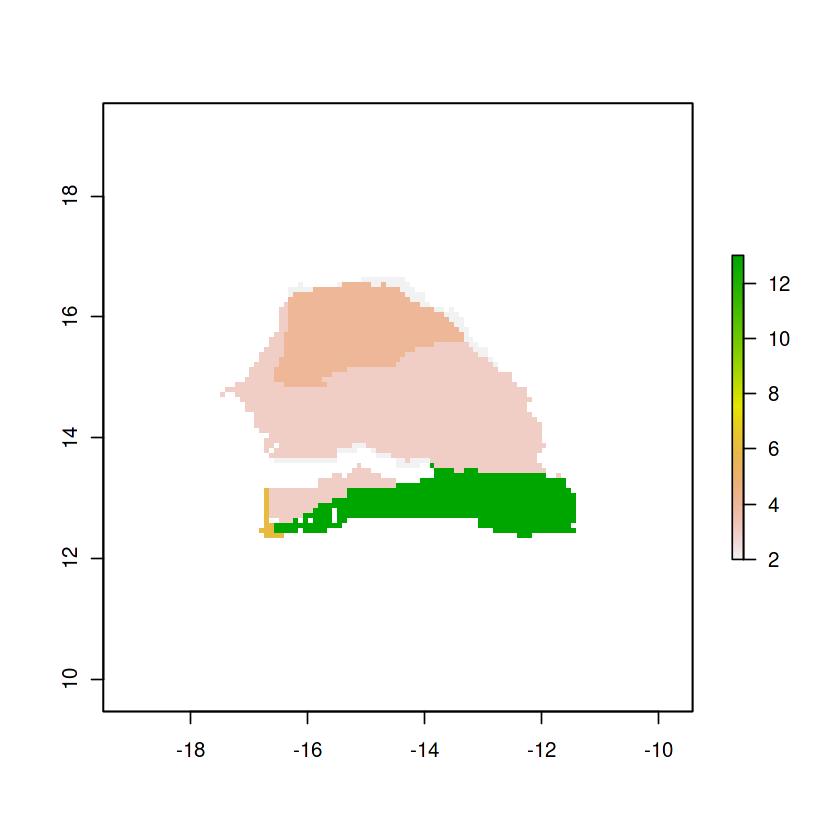

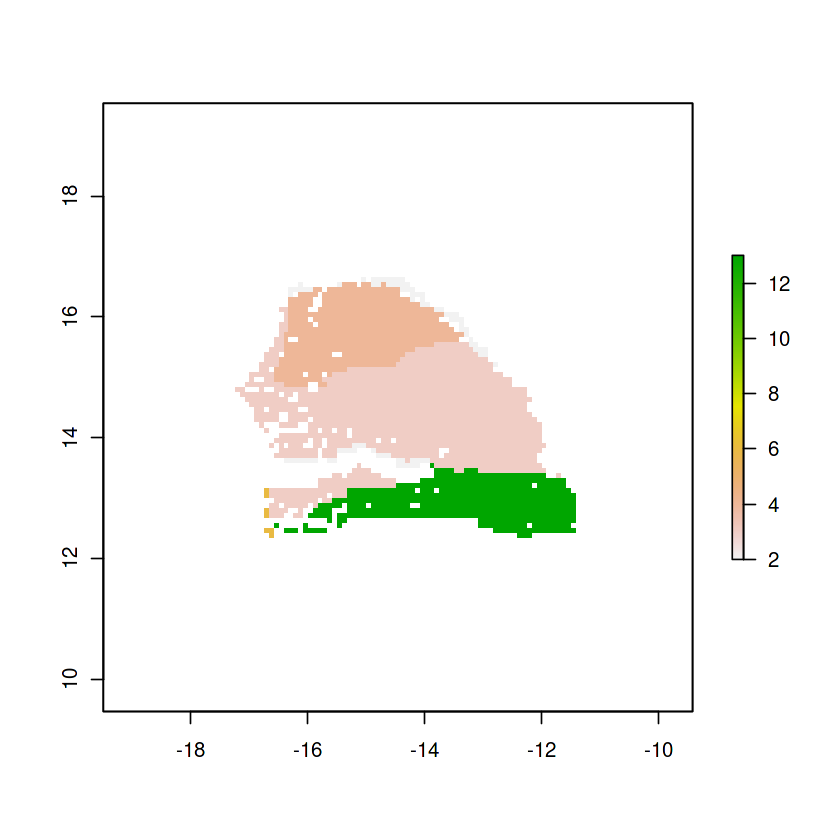

In [21]:
#create live layer
vlstk <- raster("ONECGIAR/ANIMALS/prioritization/exposure/livestock_vop/cell5m_livestock_vop.tif") %>%
  raster::crop(., cmsk) %>%
  raster::mask(., cmsk)
#2. Use Dixon (2012) farming system map to compute exposure to hazards
#   a. physical area (just pixels)
#   b. rural population
#   c. VoP crops
#   d. VoP livestock
#farming systems map
fs2012 <- readOGR("AICCRA/CSAIPs/data/farming_sys/fs_dissolve.shp")
fs2012$VALUE <- 1:nrow(fs2012)
fs2012_rs <- rasterize(fs2012, cmsk, field="VALUE") %>%
  raster::mask(., cmsk)
writeRaster(fs2012_rs, "AICCRA/CSAIPs/data/farming_sys/fs_dissolve_senegal.tiff",overwrite=TRUE)
plot(fs2012_rs)
maskcrop1 <- raster::mask(fs2012_rs, vcrop) 
masklive1 <- raster::mask(maskcrop1, vlstk) 
testmap2 <- raster::mask(masklive1, rpop)
plot(testmap2)

In [26]:
#fs maps
png(file="AICCRA/CSAIPs/OUTPUT_KEN_SEN/output/fs_map_SEN.png", res=300, height=13, width=18, units="cm")
par(mar=c(1, 1, 1, 1))
#colors distinct from hazard color scheme
breaks <- c(1,2,3,4,6,13)
cols <- brewer.pal(n = 8, name = "Set2")
leg.txt <- c("Irrigated", "Agro-pastoral", 
             "Pastoral", "Artisanal fishing","Cereal-root crop mixed")
plot(testmap2, col=cols, breaks = breaks, legend = F, axes = FALSE, box = FALSE)
plot(shp_dis, add=TRUE)
legend("bottomleft", legend = leg.txt, col = cols, inset = c(-0.01,.01), 
       pch = 15, box.col = "transparent", bg = "transparent", text.col = "black",
       cex = 0.85, title = "Farming systems")
dev.off()

png 
  2

In [27]:
#f.s. table
fsnames <- fs2012@data %>%
  dplyr::rename(FULLNAME=FS_2012_NA)
#change f.s. names
fsnames$LABEL <- NA; fsnames$LABEL[1] <- "Unassigned"; fsnames$LABEL[2] <- "Irrigated"
fsnames$LABEL[3] <- "Agro-pastoral"; fsnames$LABEL[4] <- "Pastoral"; fsnames$LABEL[5] <- "Arid pastoral oases"
fsnames$LABEL[6] <- "Artisanal fishing"; fsnames$LABEL[7] <- "Perennial mixed"
fsnames$LABEL[8] <- "Humid lowland tree crop"; fsnames$LABEL[9] <- "Forest-based"
fsnames$LABEL[10] <- "Highland perennial"; fsnames$LABEL[11] <- "Highland mixed"
fsnames$LABEL[12] <- "Root and tuber crop"; fsnames$LABEL[13] <- "Cereal-root crop mixed"
fsnames$LABEL[14] <- "Maize mixed"
#full table
#note use testmap2 to mask pop, crop and live area
out_tab <- rasterToPoints(testmap2) %>% 
  as.data.frame(.) %>%
  setNames(c('x', 'y', 'VALUE')) %>%
  dplyr::inner_join(., fsnames, by='VALUE')

In [29]:
#extract hazard values, physical area, rural pop, crop vop, livestock vop
out_tab <- out_tab %>%
  dplyr::mutate(HAZARD=raster::extract(rhaz, .[,c('x','y')])) %>%
  dplyr::mutate(HAZARD_BIN=raster::extract(rhaz_bin, .[,c('x','y')])) %>%
  dplyr::mutate(PAREA=raster::extract(area_rs, .[,c('x','y')])) %>%
  dplyr::mutate(RURALPOP=raster::extract(rpop, .[,c('x','y')])) %>%
  dplyr::mutate(CVOP=raster::extract(vcrop, .[,c('x','y')])) %>%
  dplyr::mutate(LVOP=raster::extract(vlstk, .[,c('x','y')])) %>%
  dplyr::mutate(LVOPTOT=LVOP) %>%
  tidyr::drop_na(.)
#table 1: frequencies of pixels in each hazard category per farming system (incl. no hazard)
tab1 <- as.data.frame(table(out_tab$HAZARD, out_tab$LABEL)) %>%
  dplyr::rename(HAZARD=Var1, FarmSyst=Var2) %>%
  dplyr::mutate(HAZARD=as.numeric(paste(HAZARD))) %>%
  dplyr::left_join(., haz_lab, by='HAZARD') %>%
  dplyr::group_by(FarmSyst) %>%
  dplyr::mutate(RelFreq = prop.table(Freq)) %>%
  as.data.frame(.) %>%
  dplyr::mutate(RelFreq = RelFreq * 100)

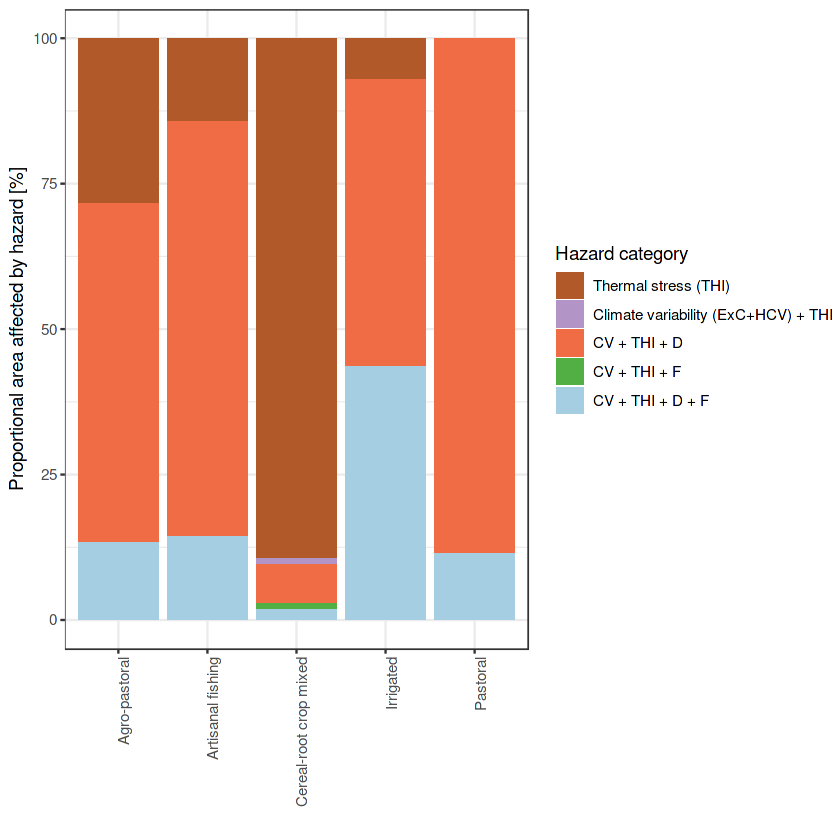

In [52]:
#order of farming systems for plotting x-axis
fsorder <- tab1 %>%
  dplyr::filter(HAZARD != 0) %>%
  dplyr::group_by(FarmSyst) %>%
  dplyr::summarise_at(., vars(RelFreq), sum, na.rm=TRUE) %>%
  as.data.frame(.)
fsorder <- fsorder$FarmSyst[order(fsorder$RelFreq, decreasing=TRUE)]
#color palette
colourCount <- length(unique(tab1$HAZ_LAB))
getPalette <- colorRampPalette(brewer.pal(12, "Paired"))
gplot <- ggplot(tab1, aes(x=factor(FarmSyst, levels=fsorder), y=RelFreq, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  xlab("") + 
  ylab("Proportional area affected by hazard [%]")
print(gplot)

In [33]:
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_proportion_allcat_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

In [35]:
#table 2: frequencies of pixels in each hazard category per farming system (excl. no hazard)
tab2 <- as.data.frame(table(out_tab$HAZARD, out_tab$LABEL)) %>%
  dplyr::rename(HAZARD=Var1, FarmSyst=Var2) %>%
  dplyr::mutate(HAZARD=as.numeric(paste(HAZARD))) %>%
  dplyr::left_join(., haz_lab, by='HAZARD') %>%
  dplyr::group_by(FarmSyst) %>%
  dplyr::mutate(RelFreq = prop.table(Freq)) %>%
  as.data.frame(.) %>%
  dplyr::mutate(RelFreq = RelFreq * 100) %>%
  dplyr::filter(HAZARD != 0)

#color palette
colourCount <- length(unique(tab1$HAZ_LAB)) 
getPalette <- colorRampPalette(brewer.pal(12, "Paired"))

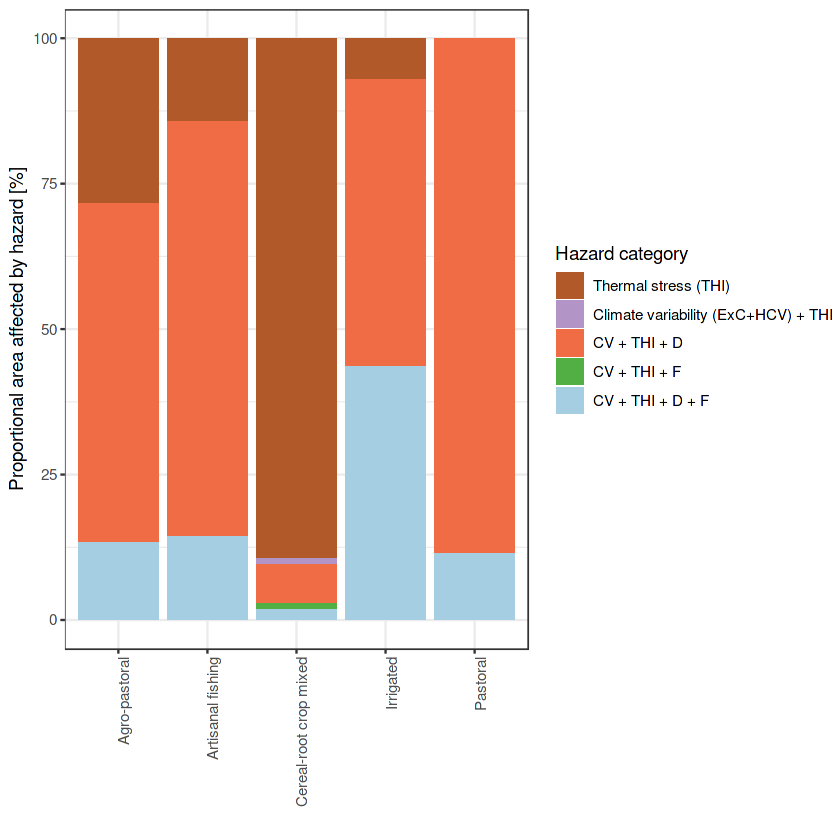

In [36]:
gplot <- ggplot(tab2, aes(x=factor(FarmSyst, levels=c("Agro-pastoral","Artisanal fishing", "Cereal-root crop mixed", "Irrigated", "Pastoral")), y=RelFreq, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  ylim(c(0,100)) +
  xlab("") + 
  ylab("Proportional area affected by hazard [%]")
print(gplot)

In [37]:
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_proportion_onlyhaz_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

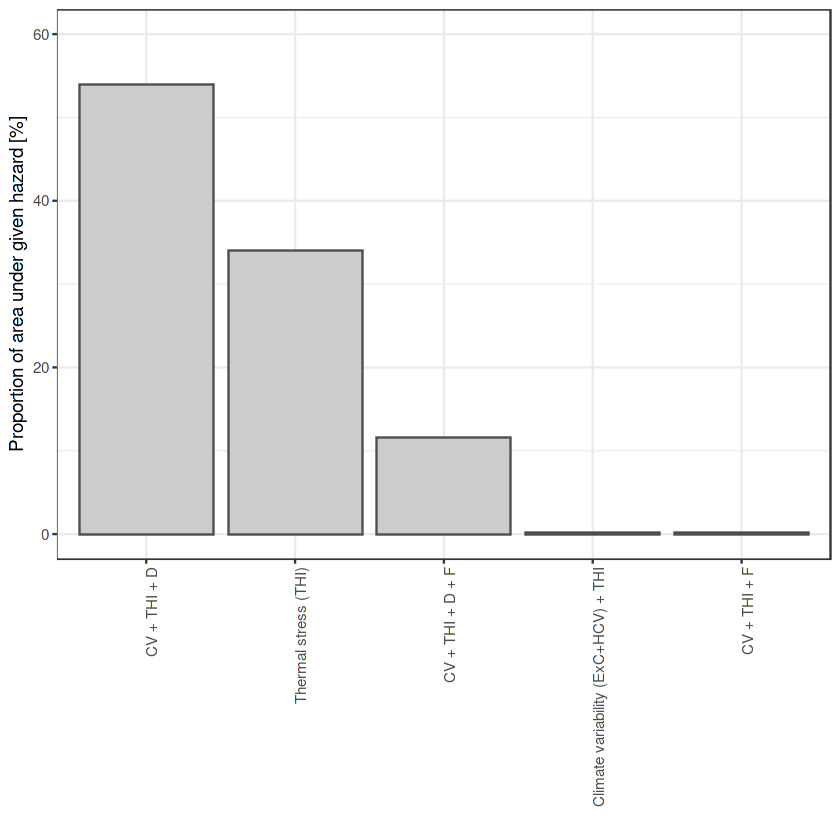

In [42]:
#table 3: total of each hazard category for the entire region
tab3 <- as.data.frame(table(out_tab$HAZARD)) %>%
  dplyr::rename(HAZARD=Var1) %>%
  dplyr::mutate(HAZARD=as.numeric(paste(HAZARD))) %>%
  dplyr::left_join(., haz_lab, by='HAZARD') %>%
  dplyr::mutate(RelFreq = prop.table(Freq)) %>%
  as.data.frame(.) %>%
  dplyr::mutate(RelFreq = RelFreq * 100) %>%
  dplyr::filter(HAZARD != 0)

gplot <- ggplot(tab3, aes(x=reorder(HAZ_LAB, -RelFreq), y=RelFreq)) + 
  geom_bar(stat="identity", color="grey 30", fill="grey 80") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("") + 
  ylab("Proportion of area under given hazard [%]") +
  ylim(c(0, 60))
print(gplot)
ggsave(gplot, filename=paste(wd,"/output/hazards_region_proportion_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=13, units="cm")

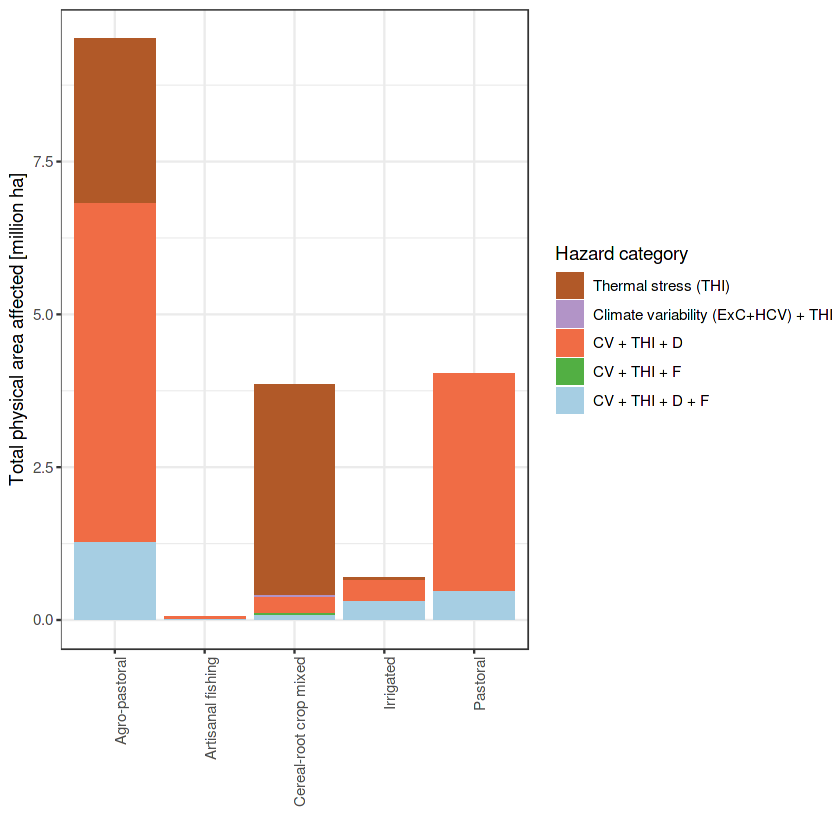

In [49]:
#table 4: sum of area, people, vop crops and vop livestock
#PAREA: in km2, times 100 gives ha, then divide by 10^6 (so just divide by 10^4) for million ha
#RURALPOP: in people, divide by 10^6 to get million
#CVOP: in USD, divide by 10^9 to get billion
#LVOPTOT: in 000 USD, i divide by 10^7 to get billion***check
tab4 <- out_tab %>%
  dplyr::rename(FarmSyst=LABEL) %>%
  dplyr::select(-FULLNAME, -VALUE, -LVOP) %>%
  dplyr::group_by(FarmSyst, HAZARD) %>%
  dplyr::summarise_at(., vars(PAREA:LVOPTOT), sum, na.rm=TRUE) %>%
  dplyr::left_join(., haz_lab, by="HAZARD") %>%
  dplyr::relocate(HAZ_LAB, .after=HAZARD) %>%
  dplyr::mutate(PAREA=PAREA/10^4, RURALPOP=RURALPOP/10^6, 
                CVOP=CVOP/10^9, LVOPTOT=LVOPTOT/10^7) %>%
  dplyr::mutate(TOTALVOP=CVOP+LVOPTOT) %>%
  dplyr::filter(HAZARD != 0)

#order of farming systems for plotting x-axis
fsorder_tab4 <- tab4 %>%
  dplyr::group_by(FarmSyst) %>%
  dplyr::summarise_at(., vars(PAREA), sum, na.rm=TRUE) %>%
  as.data.frame(.)
fsorder_tab4 <- fsorder_tab4$FarmSyst[order(fsorder_tab4$PAREA, decreasing=TRUE)]

#color palette
colourCount <- length(unique(tab1$HAZ_LAB))
getPalette <- colorRampPalette(brewer.pal(12, "Paired"))

#physical area plot
gplot <- ggplot(tab4, aes(x=factor(FarmSyst, levels=c("Agro-pastoral","Artisanal fishing", "Cereal-root crop mixed", "Irrigated", "Pastoral")), y=PAREA, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  xlab("") + 
  ylab("Total physical area affected [million ha]")

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_parea_onlyhaz_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

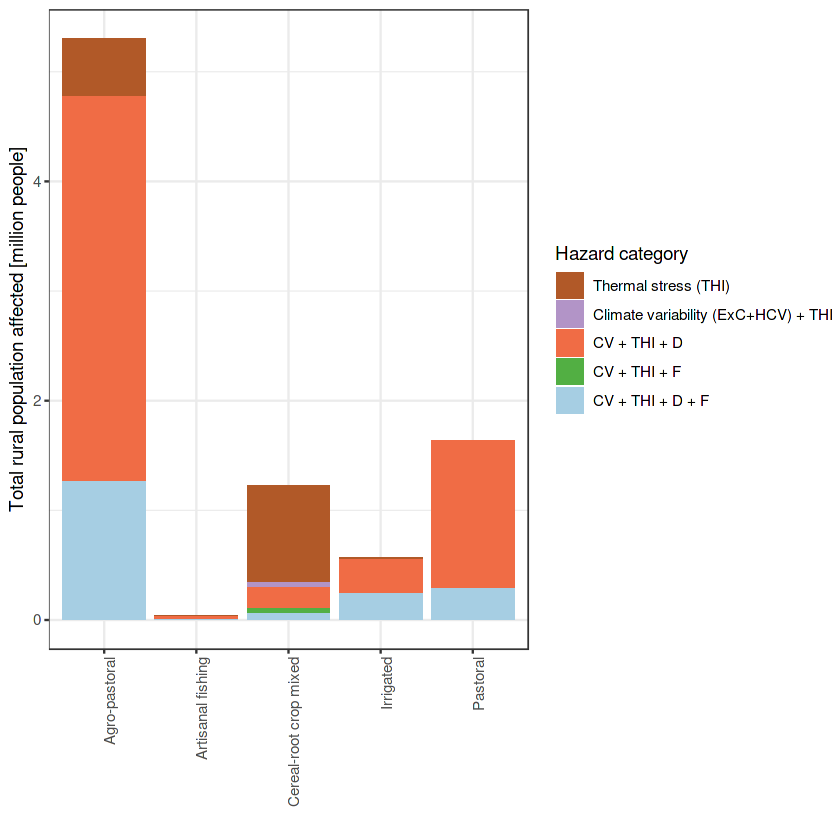

In [56]:
#rural population plot
gplot <- ggplot(tab4, aes(x=factor(FarmSyst, levels=c("Agro-pastoral","Artisanal fishing", "Cereal-root crop mixed", "Irrigated", "Pastoral")), y=RURALPOP, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  xlab("") + 
  ylab("Total rural population affected [million people]")

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_ruralpop_onlyhaz_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

In [53]:
#remove artisanal fishing
tab4_new <- filter(tab4, FarmSyst != "Artisanal fishing")

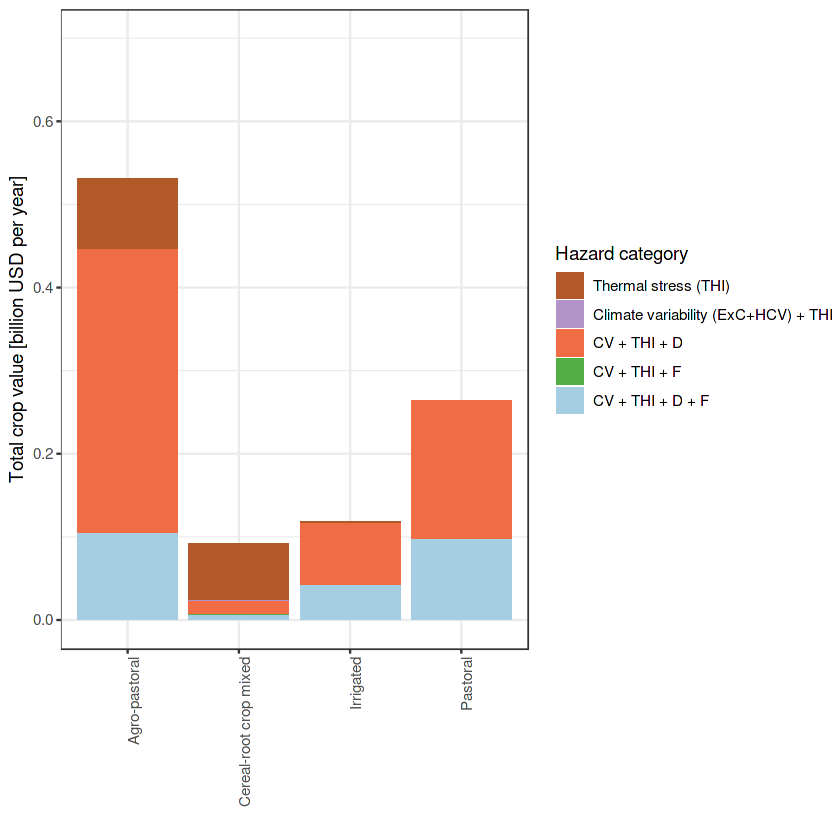

In [60]:
#crop vop plot
#adjust scales accordingly
gplot <- ggplot(tab4_new, aes(x=factor(FarmSyst, levels=c("Agro-pastoral","Cereal-root crop mixed", "Irrigated", "Pastoral")), y=CVOP, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  xlab("") + 
  ylab("Total crop value [billion USD per year]") +
  ylim(c(0,.7))

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_cropVoP_onlyhaz_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

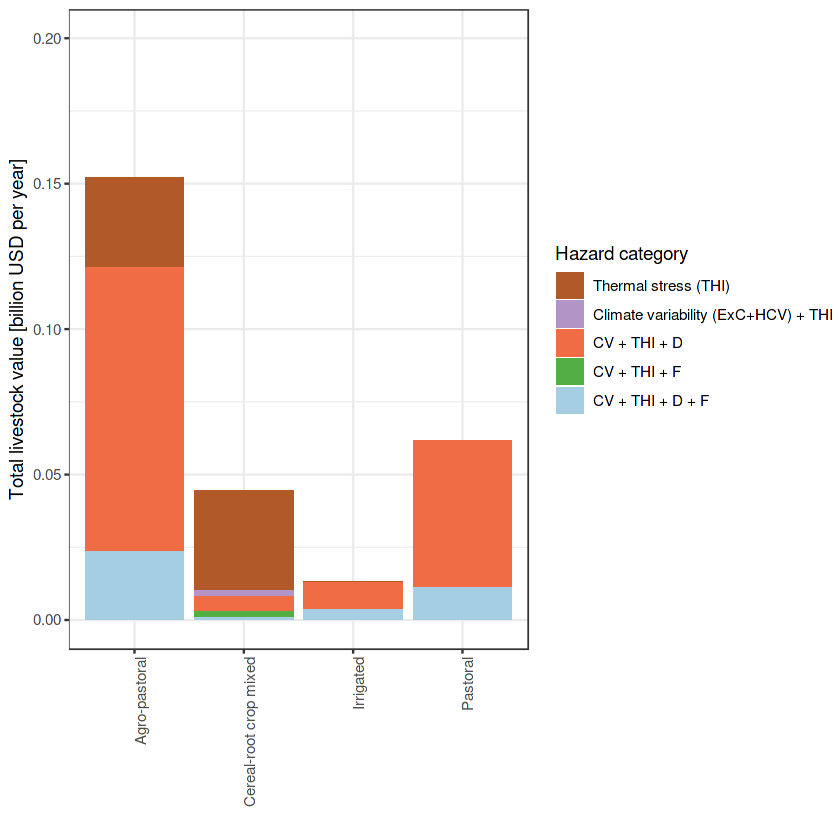

In [62]:
#livestock vop plot
#adjust scales accordingly
gplot <- ggplot(tab4_new, aes(x=factor(FarmSyst, levels=c("Agro-pastoral","Cereal-root crop mixed", "Irrigated", "Pastoral")), y=LVOPTOT, fill=factor(HAZ_LAB, levels=paste(haz_lab$HAZ_LAB)))) + 
  geom_bar(stat="identity", position="stack") +
  scale_fill_manual(values = rev(getPalette(colourCount))) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill="Hazard category") +
  xlab("") + 
  ylab("Total livestock value [billion USD per year]") +
  ylim(c(0,.2))

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/hazards_fs_stacked_livestockVoP_onlyhaz_SEN_cam.png",sep=""), 
       dpi=300, height=13, width=18, units="cm")

In [66]:
#hazard maps
png(file="AICCRA/CSAIPs/OUTPUT_KEN_SEN/output/hazards_map_SEN_cam.png", res=300, height=13, width=18, units="cm")

par(mar=c(1, 1, 1, 1))
#fix colors consistent with other graphs
# Hexadecimal color specification 
library(RColorBrewer)
brewer.pal(n = 11, name = "Paired")
cols <- c("lightgrey","gold","#6A3D9A","#FFFF99","#CAB2D6" , "orangered",  "firebrick", "tan3", "slateblue1","seagreen2", "#A6CEE3")
leg.txt <- c("No hazard", "Extreme high climate var. (ExC)", "High climate variability (CV)", "Thermal stress (THI)",
                                "ExC + HCV + THI", "CV + Drought (D)", "CV + Flood (F)", "CV + THI + D", "CV + THI + F",
                                "CV + D + F", "CV + THI + D + F")
plot(testmap2, col=cols, legend = F, axes = FALSE, box = FALSE)
plot(shp_dis, add=TRUE)
legend("bottomleft", legend = leg.txt, col = cols,inset = c(-0.01,.01), 
       pch = 15, box.col = "transparent", bg = "transparent", text.col = "black", 
       cex = 0.80)
dev.off()

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99"

png 
  2

In [94]:
png(file="AICCRA/CSAIPs/OUTPUT_KEN_SEN/output/hazards_map_SEN1_cam.png", res=300, height=13, width=18, units="cm")
par(mar=c(1, 1, 1, 1))
#fix colors consistent with other graphs
# Hexadecimal color specification 
library(RColorBrewer)
cols <- c("gold","#6A3D9A","#FFFF99","#CAB2D6" , "orangered",  "firebrick", "tan3", "slateblue1","seagreen2", "#A6CEE3")
leg.txt <- c("Extreme high climate var. (ExC)", "High climate var. (CV)", "Thermal stress (THI)",
                                "ExC + HCV + THI", "CV + Drought (D)", "CV + Flood (F)", "CV + THI + D", "CV + THI + F",
                                "CV + D + F", "CV + THI + D + F")
plot(testmap2, col=cols, legend = F, axes = FALSE, box = FALSE)
plot(shp_dis, add=TRUE)
legend("bottomleft", legend = leg.txt, col = cols,inset = c(-0.02,.03), 
       pch = 15, box.col = "transparent", bg = "transparent", text.col = "black", 
       cex = 0.80)
dev.off()

png 
  2

In [95]:
#3. Suitability changes as for USAID ZoI analysis (i.e. by farming system)
#calculate f.s. proportions
#full table
fsrs_tb <- rasterToPoints(fs2012_rs) %>% 
  as.data.frame(.) %>%
  setNames(c('x', 'y', 'VALUE')) %>%
  dplyr::left_join(., fsnames, by='VALUE')
#frequency table
freqtab <- as.data.frame(table(fsrs_tb$LABEL)) %>%
  dplyr::mutate(RelFreq=Freq/sum(Freq)) %>%
  dplyr::rename(FarmSyst=Var1)
#load f.s. crop matrix
crop_tbl <- read_xlsx(path=paste("AICCRA/CSAIPs/data/farming_sys/crop_farm_system_table_rbj.xlsx",sep=""), 
                      sheet="FarmSyst_crops") %>%
  dplyr::filter(Region %in% c("Senegal")) %>%
  dplyr::rename(FULLNAME=`Farming system`) %>%
  as.data.frame(.) %>%
  dplyr::left_join(., fsnames, by="FULLNAME") %>%
  dplyr::relocate(c(VALUE, LABEL), .before=FULLNAME) %>%
  tidyr::pivot_longer(., cols=`african rice`:yams, values_to='crop_pa') %>%
  dplyr::rename(cropname=name, FarmSyst=LABEL) %>%
  dplyr::select(-FULLNAME) %>%
  dplyr::left_join(., freqtab, by="FarmSyst")

In [96]:
head(crop_tbl)

Region,VALUE,FarmSyst,cropname,crop_pa,Freq,RelFreq
<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>
Senegal,3,Agro-pastoral,african rice,0,1253,0.5282462
Senegal,3,Agro-pastoral,banana,0,1253,0.5282462
Senegal,3,Agro-pastoral,barley,1,1253,0.5282462
Senegal,3,Agro-pastoral,bean,1,1253,0.5282462
Senegal,3,Agro-pastoral,cassava,1,1253,0.5282462
Senegal,3,Agro-pastoral,chickpea,1,1253,0.5282462


In [97]:
#read crop suitability from Ani
suit_tab <- read.csv(paste("AICCRA/CSAIPs/data/farming_sys/all_country_suitability_stat_all_rcp85_2050.csv")) %>%
  dplyr::filter(ISO %in% sadc) %>%
  dplyr::group_by(cropname) %>%
  dplyr::summarise_at(., vars(cur_suit:less_suit_fut), sum, na.rm=TRUE) %>%
  dplyr::mutate(RELCHG=less_suit_fut / cur_suit * 100) %>%
  dplyr::mutate(ABSCHG_km2 = less_suit_fut * (0.0416666 * 111.19)^2) %>%
  dplyr::mutate(ABSCHG_Mha = ABSCHG_km2 / 10^4)

#table 5: suitability for the whole region
tab5 <- crop_tbl %>%
  dplyr::group_by(cropname) %>%
  dplyr::summarise_at(., vars(crop_pa), sum, na.rm=TRUE) %>%
  dplyr::left_join(., suit_tab, by="cropname") %>%
  dplyr::filter(crop_pa != 0)

Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (position_stack).”


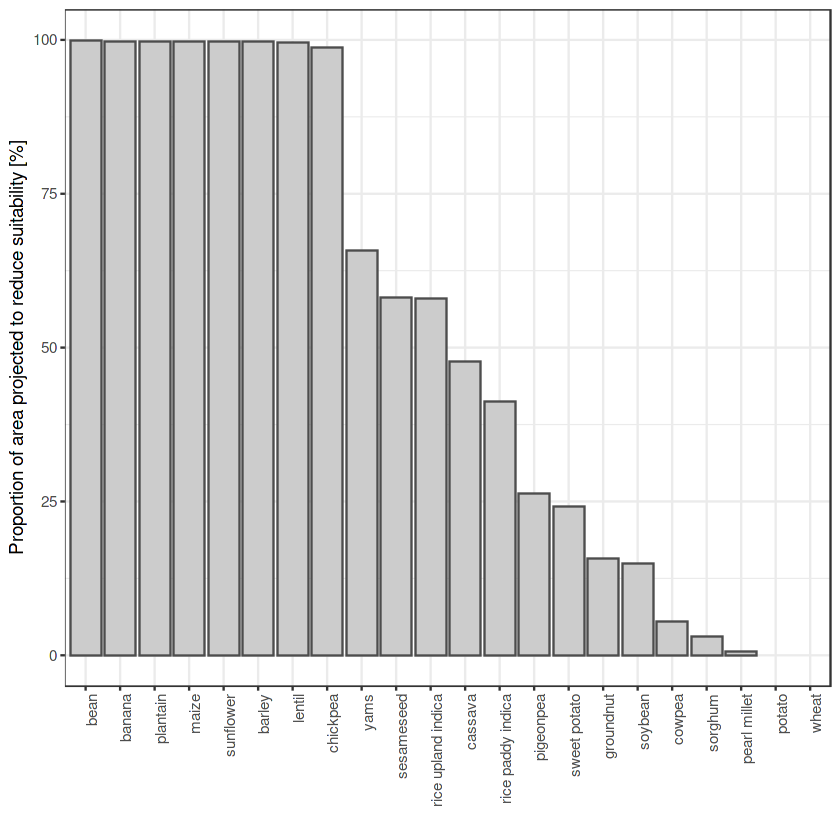

In [98]:
#plot crop suitability change per crop (relative)
gplot <- ggplot(tab5, aes(x=reorder(cropname, -RELCHG), y=RELCHG)) + 
  geom_bar(stat="identity", color="grey 30", fill="grey 80") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("") + 
  ylab("Proportion of area projected to reduce suitability [%]") +
  ylim(c(0, 100))

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/suitability_change_region_relative_crop_SEN.png",sep=""), 
       dpi=300, height=13, width=16, units="cm")

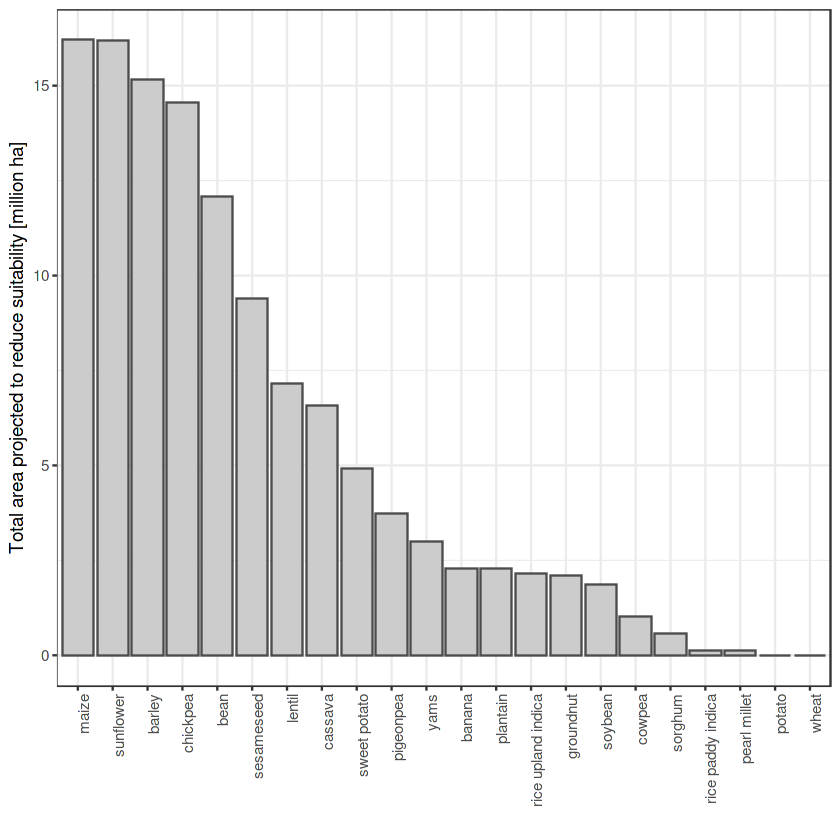

In [99]:
#plot crop suitability change per crop (relative)
gplot <- ggplot(tab5, aes(x=reorder(cropname, -ABSCHG_Mha), y=ABSCHG_Mha)) + 
  geom_bar(stat="identity", color="grey 30", fill="grey 80") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("") + 
  ylab("Total area projected to reduce suitability [million ha]")

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/suitability_change_region_absolute_SEN.png",sep=""), 
       dpi=300, height=13, width=16, units="cm")

In [102]:
#read crop suitability from Ani (f.s. times country)
suit_tab2 <- read.csv(paste("AICCRA/CSAIPs/data/farming_sys/cg_country_fs_suitability_stat_all_rcp85_2050.csv")) %>%
  dplyr::filter(ISO %in% sadc) %>%
  dplyr::group_by(cropname, farming_system) %>%
  dplyr::summarise_at(., vars(cur_suit:less_suit_fut), sum, na.rm=TRUE) %>%
  dplyr::mutate(RELCHG=less_suit_fut / cur_suit * 100) %>%
  dplyr::mutate(ABSCHG_km2 = less_suit_fut * (0.0416666 * 111.19)^2) %>%
  dplyr::mutate(ABSCHG_Mha = ABSCHG_km2 / 10^4) %>%
  dplyr::rename(FULLNAME=farming_system) %>%
  dplyr::left_join(., fsnames, by="FULLNAME") %>%
  dplyr::relocate(LABEL, .after=cropname) %>%
  dplyr::select(-FULLNAME, -VALUE) %>%
  dplyr::rename(FarmSyst=LABEL) %>%
  dplyr::left_join(., crop_tbl, by=c("FarmSyst","cropname")) %>%
  dplyr::relocate(crop_pa:RelFreq, .after=FarmSyst) %>%
  dplyr::select(-Region, -VALUE)

In [103]:
#if no current suitability then set RELCHG=0
suit_tab2$RELCHG[which(suit_tab2$cur_suit == 0)] <- 0

#if no presence then set RELCHG=NA, ABSCHG_km2 = NA, ABSCHG_Mha = NA
suit_tab2$RELCHG[which(suit_tab2$crop_pa == 0)] <- NA
suit_tab2$ABSCHG_km2[which(suit_tab2$crop_pa == 0)] <- NA
suit_tab2$ABSCHG_Mha[which(suit_tab2$crop_pa == 0)] <- NA

#table 6: suitability per f.s. for the whole region
tab6 <- suit_tab2 %>%
  dplyr::group_by(FarmSyst) %>%
  dplyr::summarise_at(., vars(Freq, RelFreq, RELCHG:ABSCHG_Mha), mean, na.rm=TRUE) %>%
  dplyr::mutate(WRELCHG = RELCHG * RelFreq) %>%
  dplyr::filter(!FarmSyst %in% c("Arid pastoral oases", "Artisanal fishing", "Irrigated")) %>%
  dplyr::mutate(RelFreq = RelFreq * 100)

total_red <- sum(tab6$WRELCHG, na.rm=TRUE)

In [104]:
tab6

FarmSyst,Freq,RelFreq,RELCHG,ABSCHG_km2,ABSCHG_Mha,WRELCHG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Agro-pastoral,1253,52.82462,45.48690,33928.695553,3.3928695553,24.028282
Cereal-root crop mixed,491,20.69983,36.24783,12568.058725,1.2568058725,7.503239
Pastoral,516,21.75379,15.29834,5644.992065,0.5644992065,3.327970
NA,NaN,NaN,20.83333,4.471635,0.0004471635,NaN


In [106]:
#remove NA
tab6_new <- filter(tab6, FarmSyst != "NA")

In [107]:
tab6_new

FarmSyst,Freq,RelFreq,RELCHG,ABSCHG_km2,ABSCHG_Mha,WRELCHG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Agro-pastoral,1253,52.82462,45.48690,33928.696,3.3928696,24.028282
Cereal-root crop mixed,491,20.69983,36.24783,12568.059,1.2568059,7.503239
Pastoral,516,21.75379,15.29834,5644.992,0.5644992,3.327970


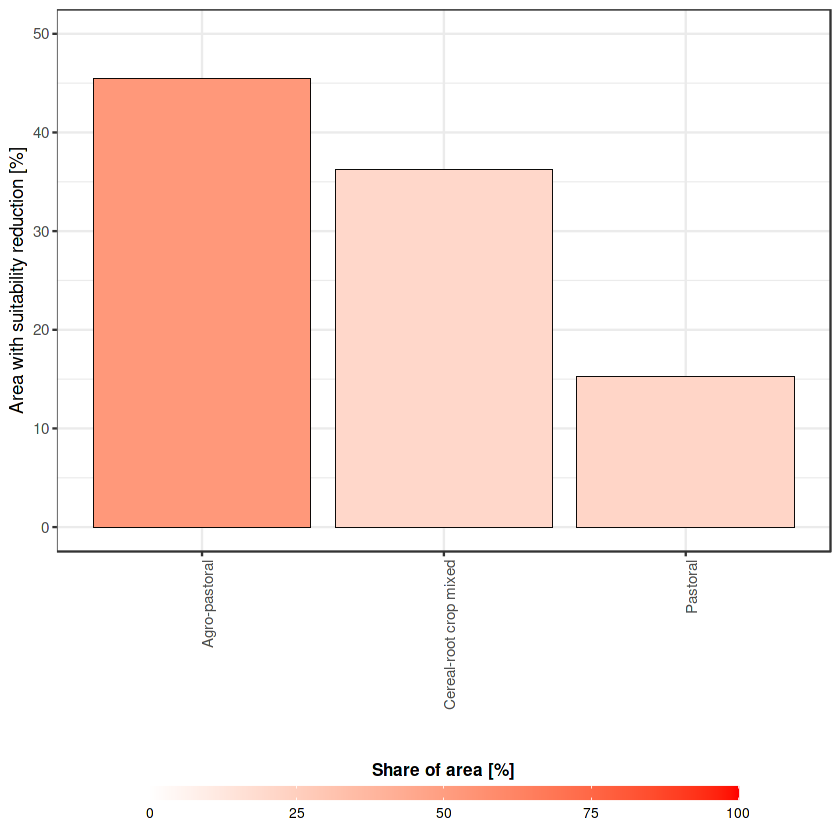

In [108]:
#RELCHG with fill being RelFreq
  gplot10 <- ggplot(tab6_new, aes(x=reorder(FarmSyst, -RELCHG), y=RELCHG, fill=RelFreq)) + 
  geom_bar(stat="identity", color="black", size=0.2) +
  scale_fill_continuous(low="white", high="red", limits=c(0, 100)) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("") + 
  ylab("Area with suitability reduction [%]") +
  labs(fill="Share of area [%]") +
  ylim(c(0,50)) +
  guides(fill = guide_colorbar(title.position = "top",
                             title.hjust = 0.5)) +
  theme(legend.direction = "horizontal", 
        legend.box = "vertical",
        legend.position="bottom",
        legend.key.size = unit(2.5, 'cm'), #change legend key size
        legend.key.height = unit(0.3, 'cm'), #change legend key height
        legend.key.width = unit(2.5, 'cm'), #change legend key width
        legend.title = element_text(size=10, face="bold"), #change legend title font size
        legend.text = element_text(size=8)) #change legend text font size

print(gplot10)


In [109]:
ggsave(gplot10, filename=paste(wd,"/output/suitability_relchg_FarmSyst_SEN.png",sep=""), dpi=300, 
       height=13, width=15, units="cm")

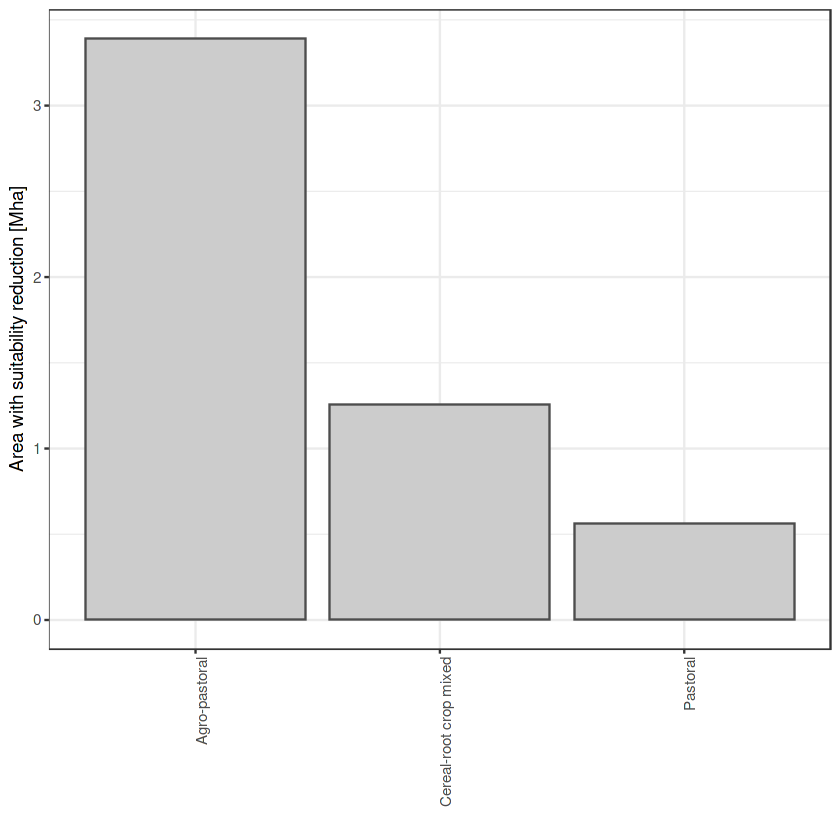

In [110]:
#RELCHG with fill being RelFreq
gplot <- ggplot(tab6_new, aes(x=reorder(FarmSyst, -ABSCHG_Mha), y=ABSCHG_Mha)) + 
  geom_bar(stat="identity", color="grey 30", fill="grey 80") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("") + 
  ylab("Area with suitability reduction [Mha]")

print(gplot)
ggsave(gplot, filename=paste(wd,"/output/suitability_abschg_FarmSyst_SEN.png",sep=""), dpi=300, 
       height=10.5, width=13, units="cm")